<div style="color:white;
            display:fill;
            border-radius:5px;
            background-color:#da5351;
            font-size:130%;
            font-family:Verdana;
            letter-spacing:0.5px;
            text-align:center">
  <h1 id="Lung Cancer Detection using CNN" style="padding: 10px; color:white; text-align:center;">
    Lung Cancer Detection using CNN
    <a class="anchor-link" href="https://www.kaggle.com/code/amirhoseinsedaghati/lung-cancer-detection-using-cnn-0-98-f1-acc#Lung_Cancer_Detection_using_CNN">¶</a>
  </h1>
</div>

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">
    
Welcome to this notebook :)
      
</div>

In [1]:
from google.colab import drive

# Mount Google Drive to your Colab session
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div style="color:white;
            display:fill;
            border-radius:5px;
            background-color:#44479b;
            font-size:110%;
            font-family:Verdana;
            letter-spacing:0.5px;
            text-align:center">
  <h1 id="Import and Setup Dependencies" style="padding: 10px; color:white; text-align:center;">
   1. Import and Setup Dependencies
    <a class="anchor-link" href="https://www.kaggle.com/code/amirhoseinsedaghati/lung-cancer-detection-using-cnn-0-98-f1-acc#Import_and_Setup_Dependencies"">¶</a>
  </h1>
</div>


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, SeparableConv2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import glob
import h5py
import cv2
import os
import random
import warnings
warnings.filterwarnings('ignore')

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">

Before running the following code cells, You have to change the Accelerator status from None to GPU P100, because, in this notebook, we're going to use GPU as the computing processing units. You can do this in the edit mode by clicking on the three dots located in the upper right corner.
</div>

In [3]:
# If a GPU is accessible, it will display the name of the GPU device
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
os.getcwd()

'/content'

In [5]:
os.listdir(os.getcwd())

['.config', 'drive', 'sample_data']

In [6]:
paths = {
    'train': '/content/drive/MyDrive/dataset/chest_xray/train',
    'val': '/content/drive/MyDrive/dataset/chest_xray/val',
    'test': '/content/drive/MyDrive/dataset/chest_xray/test',
}

classes = ['NORMAL', 'PNEUMONIA']

<div style="color:white;
            display:fill;
            border-radius:5px;
            background-color:#44479b;
            font-size:110%;
            font-family:Verdana;
            letter-spacing:0.5px;
            text-align:center">
  <h1 id="EDA" style="padding: 10px; color:white; text-align:center;">
    2. EDA
    <a class="anchor-link" href="https://www.kaggle.com/code/amirhoseinsedaghati/lung-cancer-detection-using-cnn-0-98-f1-acc#EDA">¶</a>
  </h1>
</div>

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">
    
<strong>2.x. Data Analytics</strong>

</div>

In [7]:
def len_files(folder_name):
    """
    return the number of files in each class
    """
    for i in range(2):
        os.chdir(os.path.join(paths[folder_name], classes[i]))
        files = sorted(os.listdir())
        len_images = 0
        len_others = 0
        for file in files:
            extension = file.split('.')[1]
            if extension == 'jpeg':
                len_images += 1
            else:
                len_others += 1
        print(f"The numebr of image files in the class {classes[i]} of the {folder_name} is {len_images}")
        print(f"The numebr of other files in the class {classes[i]} of the {folder_name} is {len_others}")
    print('--------------')

In [8]:
len_files('train')
len_files('val')
len_files('test')

The numebr of image files in the class NORMAL of the train is 1350
The numebr of other files in the class NORMAL of the train is 0
The numebr of image files in the class PNEUMONIA of the train is 3875
The numebr of other files in the class PNEUMONIA of the train is 0
--------------
The numebr of image files in the class NORMAL of the val is 8
The numebr of other files in the class NORMAL of the val is 0
The numebr of image files in the class PNEUMONIA of the val is 8
The numebr of other files in the class PNEUMONIA of the val is 0
--------------
The numebr of image files in the class NORMAL of the test is 234
The numebr of other files in the class NORMAL of the test is 0
The numebr of image files in the class PNEUMONIA of the test is 390
The numebr of other files in the class PNEUMONIA of the test is 0
--------------


In [9]:
os.getcwd()

'/content/drive/MyDrive/dataset/chest_xray/test/PNEUMONIA'

In [10]:
os.chdir(paths['train'])

In [11]:
def show_images(folder_name, class_name, num_im, random_state=42):
    im_files = os.listdir(os.path.join(paths[folder_name.lower()], class_name.upper()))
    random.seed(random_state)
    rand_images = random.choices(im_files, k=num_im)
    plt.figure(figsize=(20, 20))
    for i, im in enumerate(rand_images):
        ax = plt.subplot(num_im, 1, i + 1)
        im_arr = cv2.imread(os.path.join(paths[folder_name.lower()], class_name.upper(), im))
        ax.imshow(im_arr, cmap='gray')
        ax.set_title(f'{class_name.upper()}', alpha=.7)
        plt.axis('off')
        plt.tight_layout()

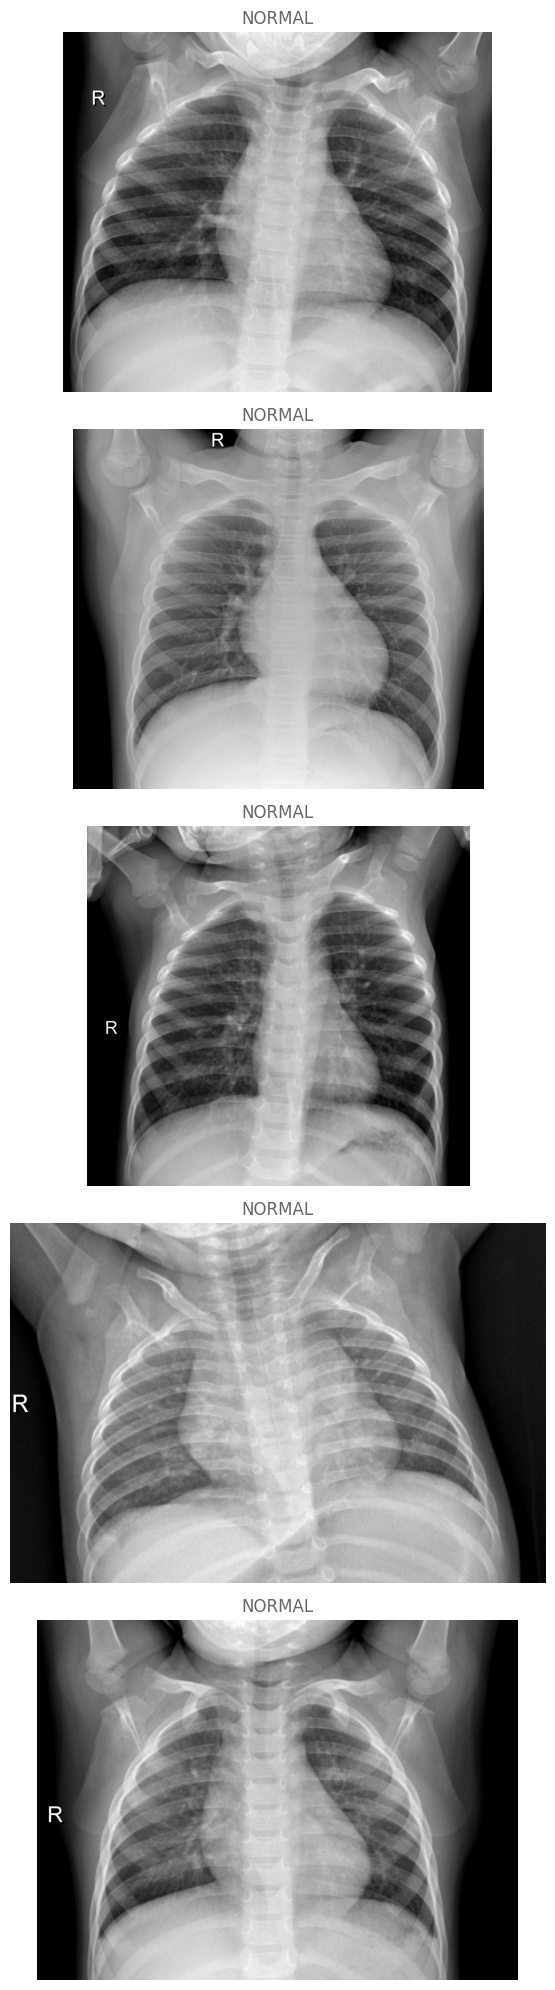

In [12]:
show_images('train', 'normal', 5)

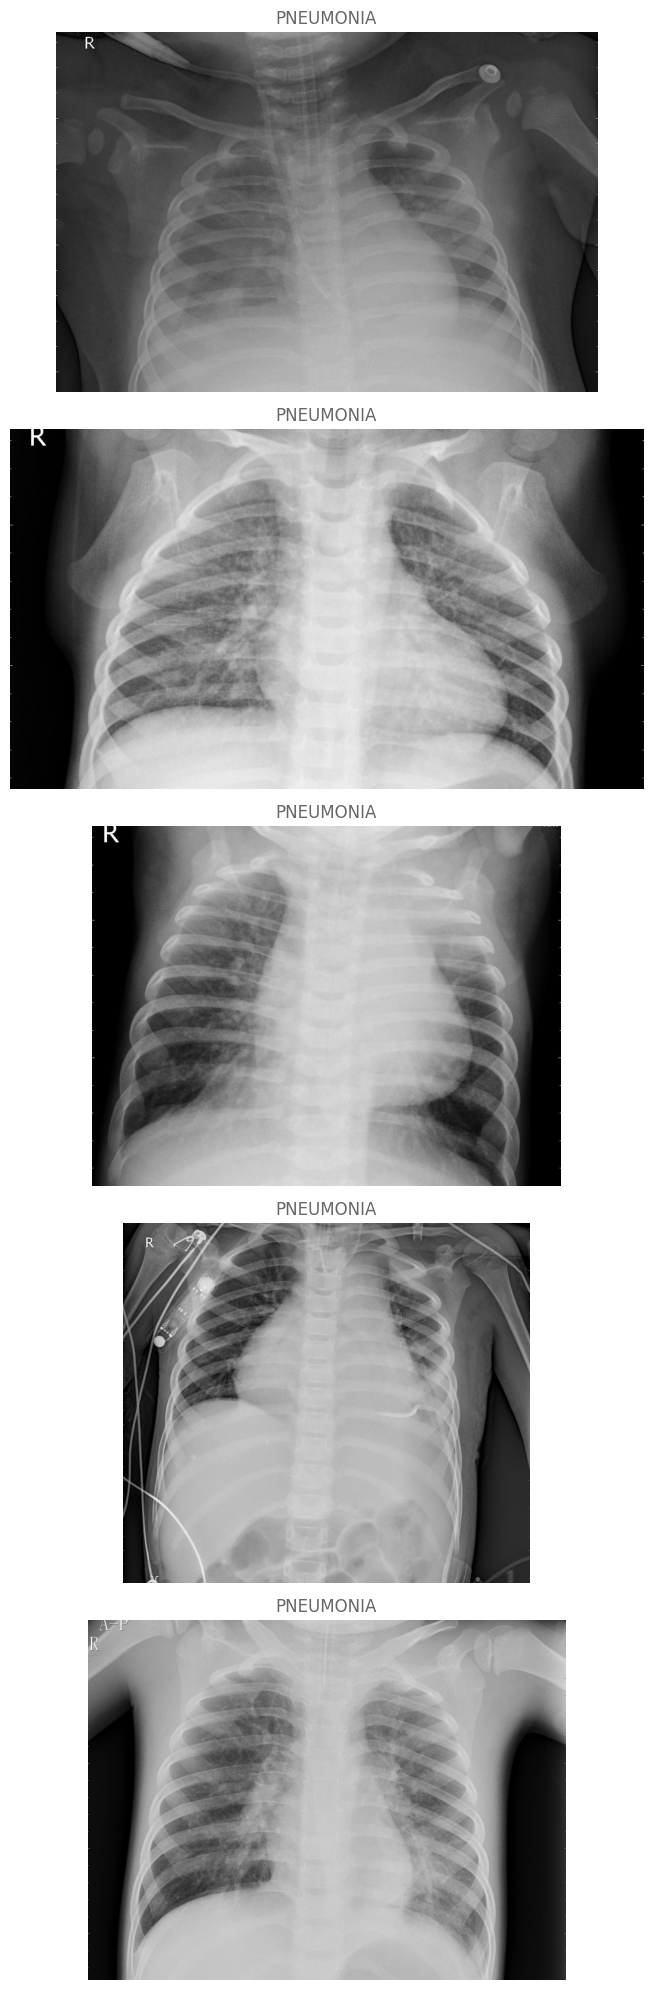

In [13]:
show_images('train', 'Pneumonia', 5)

<div style="color:white;
            display:fill;
            border-radius:5px;
            background-color:#44479b;
            font-size:110%;
            font-family:Verdana;
            letter-spacing:0.5px;
            text-align:center">
  <h1 id="Data Preprocessing" style="padding: 10px; color:white; text-align:center;">
    3. Data Preprocessing
    <a class="anchor-link" href="https://www.kaggle.com/code/amirhoseinsedaghati/lung-cancer-detection-using-cnn-0-98-f1-acc#Data_Preprocessing">¶</a>
  </h1>
</div>

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">
    
<strong>3.x. Data Agumentation</strong>

</div>

In [14]:
train_datagen = ImageDataGenerator(
    rescale= 1.0 / 255.0,
    rotation_range= 10,
    brightness_range=(0.7, 1.0)
)

test_datagen = ImageDataGenerator(rescale= 1.0 / 255.0)

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">
    
The method <code>datagen.flow_from_directory</code> creates a continuous flow of augmented data batches by reading images from a directory structure for training a machine learning model.
</div>


In [15]:
BATCH_SIZE = 16
print('Training Set:')
train_set = train_datagen.flow_from_directory(
    paths['train'],
    color_mode= 'rgb',
    class_mode= 'binary',
    target_size= (224, 224),
    batch_size= BATCH_SIZE
)

print('Test Set:')
test_set = test_datagen.flow_from_directory(
    paths['test'],
    color_mode= 'rgb',
    class_mode= 'binary',
    target_size= (224, 224),
    batch_size= BATCH_SIZE
)

Training Set:
Found 5225 images belonging to 2 classes.
Test Set:
Found 624 images belonging to 2 classes.


<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">
    
<strong>3.xx. Batches</strong>

</div>

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">
    
Here, the command <code>len(train_set)</code> indicates the number of batches for the train set.

</div>

In [16]:
len(train_set), train_set.classes

(327, array([0, 0, 0, ..., 1, 1, 1], dtype=int32))

In [17]:
(5216 // BATCH_SIZE) == len(train_set)

False

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">

Here, The command <code>len(test_set)</code> indicates the number of batches for the test set.

</div>

In [18]:
len(test_set), test_set.classes

(39,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1

In [19]:
(624 // BATCH_SIZE) == len(test_set)

True

<div style="color:white;
            display:fill;
            border-radius:5px;
            background-color:#44479b;
            font-size:110%;
            font-family:Verdana;
            letter-spacing:0.5px;
            text-align:center">
  <h1 id="Data Modeling and Evaluation" style="padding: 10px; color:white; text-align:center;">
    4. Data Modeling and Evaluation
    <a class="anchor-link" href="https://www.kaggle.com/code/amirhoseinsedaghati/lung-cancer-detection-using-cnn-0-98-f1-acc#Data_Modeling_and_Evaluation">¶</a>
  </h1>
</div>

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">
<strong>How to build a strong Convolutional Neural Network, when we have limited data? :) </strong>
</div>

In [20]:
def building_model():
    # Create a CNN architecture
    # block1
    input_layer = Input(shape=(224,224,3), name='input_layer')
    block1_conv1 = Conv2D(64, (3,3), activation='relu', padding='same', name='block1_conv1')(input_layer)
    block1_conv2 = Conv2D(64, (3,3), activation='relu', padding='same', name='block1_conv2')(block1_conv1)
    block1_pool1 = MaxPooling2D((2,2), name='block1_pool1')(block1_conv2)

    # block2
    block2_conv1 = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='block2_conv1')(block1_pool1)
    block2_conv2 = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='block2_conv2')(block2_conv1)
    block2_pool1 = MaxPooling2D((2,2), name='block2_pool1')(block2_conv2)

    # block3
    block3_conv1 = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='block3_conv1')(block2_pool1)
    block3_drop1 = Dropout(0.5, name='block3_drop1')(block3_conv1)
    block3_bn1 = BatchNormalization(name='block3_bn1')(block3_drop1)
    block3_conv2 = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='block3_conv2')(block3_bn1)
    block3_drop2 = Dropout(0.5, name='block3_drop2')(block3_conv2)
    block3_bn2 = BatchNormalization(name='block3_bn2')(block3_drop2)
    block3_conv3 = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='block3_conv3')(block3_bn2)
    block3_drop3 = Dropout(0.5, name='block3_drop3')(block3_conv3)
    block3_pool1 = MaxPooling2D((2,2), name='block3_pool1')(block3_drop3)

    # block4
    block4_conv1 = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='block4_conv1')(block3_pool1)
    block4_drop1 = Dropout(0.5, name='block4_drop1')(block4_conv1)
    block4_bn1 = BatchNormalization(name='block4_bn1')(block4_drop1)
    block4_conv2 = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='block4_conv2')(block4_bn1)
    block4_drop2 = Dropout(0.5, name='block4_drop2')(block4_conv2)
    block4_bn2 = BatchNormalization(name='block4_bn2')(block4_drop2)
    block4_conv3 = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='block4_conv3')(block4_bn2)
    block4_drop3 = Dropout(0.5, name='block4_drop3')(block4_conv3)
    block4_pool1 = MaxPooling2D((2,2), name='block4_pool1')(block4_drop3)

    # block5
    flatten = Flatten(name='flatten')(block4_pool1)
    block5_dense1 = Dense(1024, activation='relu', name='block5_dense1')(flatten)
    block5_drop1 = Dropout(0.7, name='block5_drop1')(block5_dense1)
    block5_dense2 = Dense(512, activation='relu', name='block5_dense2')(block5_drop1)
    block5_drop2 = Dropout(0.5, name='block5_drop2')(block5_dense2)
    output_layer = Dense(1, activation='sigmoid', name='output_layer')(block5_drop2)

    cnn = Model(inputs=input_layer, outputs=output_layer)


    # Now, It's time to compile it.
    cnn.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate=0.0001),
        metrics = ['binary_accuracy']
    )
    return cnn

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">
In TensorFlow, we can use the <code>tf.device()</code> context manager to specify the GPU device for operations.
</div>

In [21]:

cnn = building_model()
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool1 (MaxPooling2D  (None, 112, 112, 64)      0         
 )                                                               
                                                                 
 block2_conv1 (SeparableCon  (None, 112, 112, 128)     8896      
 v2D)                                                            
                                                                 
 block2_conv2 (SeparableCon  (None, 112, 112, 128)     17664 

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">
    
<strong>4.xx. Training Model</strong>

</div>


In [22]:
EPOCHS = 5
STEPS_PER_EPOCH = len(train_set)
VALIDATION_STEPS = len(test_set)
ES = EarlyStopping(monitor='val_loss', patience=5)
MC = ModelCheckpoint("model_weights.h5", monitor='val_loss', save_best_only=True)
RLR = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=.2)


history = cnn.fit(
    x=train_set,
    validation_data= test_set,
    epochs= EPOCHS,
    steps_per_epoch= STEPS_PER_EPOCH,
    validation_steps= VALIDATION_STEPS,
    callbacks= [ES, MC, RLR],

)

Epoch 1/5
327/327 [==============================] - 384s 1s/step - loss: 0.5797 - binary_accuracy: 0.7412 - val_loss: 0.6738 - val_binary_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 2/5
327/327 [==============================] - 181s 552ms/step - loss: 0.3290 - binary_accuracy: 0.8400 - val_loss: 0.5812 - val_binary_accuracy: 0.8494 - lr: 1.0000e-04
Epoch 3/5
327/327 [==============================] - 156s 478ms/step - loss: 0.2236 - binary_accuracy: 0.9099 - val_loss: 0.6195 - val_binary_accuracy: 0.6827 - lr: 1.0000e-04
Epoch 4/5
327/327 [==============================] - 164s 501ms/step - loss: 0.1928 - binary_accuracy: 0.9236 - val_loss: 0.4932 - val_binary_accuracy: 0.8606 - lr: 1.0000e-04
Epoch 5/5
327/327 [==============================] - 167s 510ms/step - loss: 0.1773 - binary_accuracy: 0.9328 - val_loss: 0.4803 - val_binary_accuracy: 0.8654 - lr: 1.0000e-04


<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">

<strong>4.xxx. Comparing model metrics using the history attribute</strong>
    
</div>


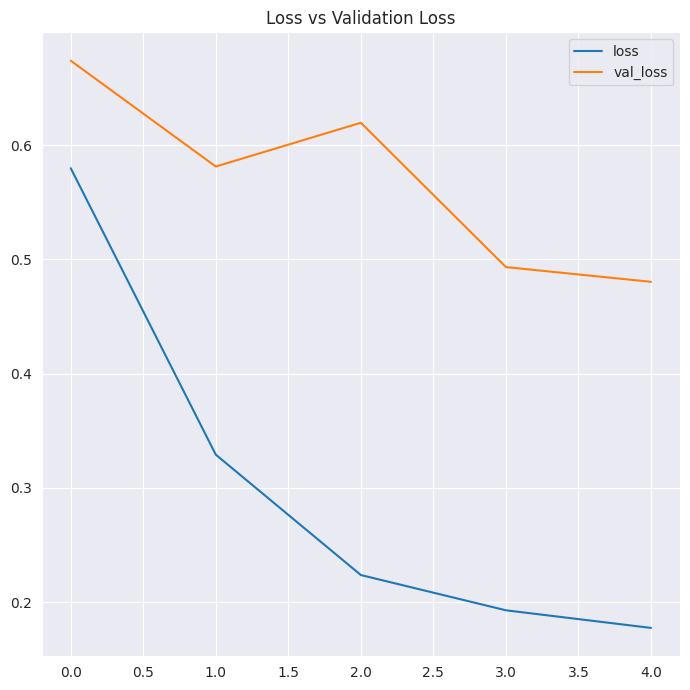

In [23]:
plt.figure(figsize=(7, 7))
plt.plot(history.history['loss'], label='loss');
plt.plot(history.history['val_loss'], label='val_loss');
plt.legend();
plt.title('Loss vs Validation Loss');
plt.tight_layout();

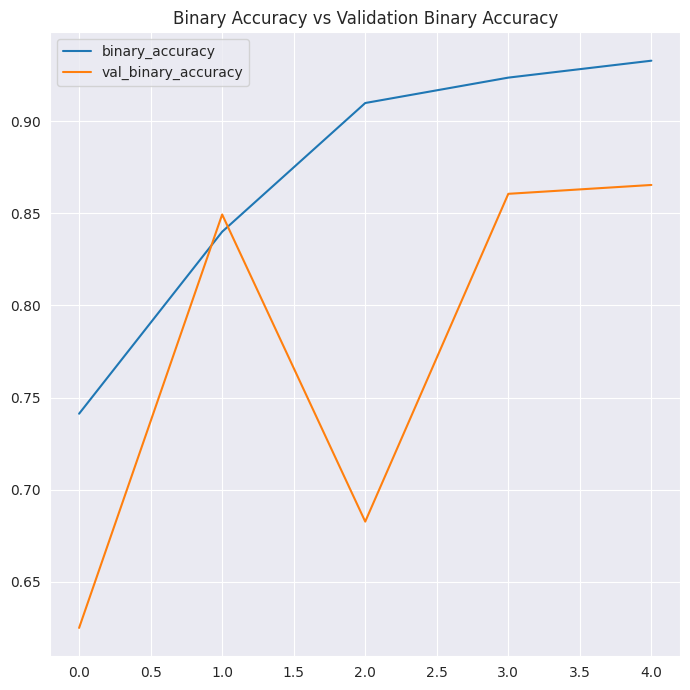

In [24]:
plt.figure(figsize=(7, 7))
plt.plot(history.history['binary_accuracy'], label='binary_accuracy');
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy');
plt.legend();
plt.title('Binary Accuracy vs Validation Binary Accuracy');
plt.tight_layout();

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">

<strong>4.xxxx. Inference and Evaluating Model</strong>

</div>


In [25]:
def get_len_smaller_50_and_len_bigger_50(y_pred_or_y_true):
    """
    Performing some tasks to find the number of items is smaller than 0.5 and to equal or bigger than 0.5
    """
    len_smaller_50 = 0
    for num in sorted(y_pred_or_y_true):
        if num < .5:
            len_smaller_50 += 1
    len_bigger_50 = len(test_set.classes) - len_smaller_50
    return len_smaller_50, len_bigger_50

In [26]:
len_smaller_50, len_bigger_50 = get_len_smaller_50_and_len_bigger_50(test_set.classes)
print(f"The number of items that are smaller than 0.5 is {len_smaller_50}")
print(f"The number of items that are equal or bigger than 0.5 is {len_bigger_50}")

The number of items that are smaller than 0.5 is 234
The number of items that are equal or bigger than 0.5 is 390


In [27]:
len_smaller_50, len_bigger_50 = get_len_smaller_50_and_len_bigger_50(cnn.predict(test_set).reshape(-1))
print(f"The number of items that are smaller than 50 is {len_smaller_50}")
print(f"The number of items that are equal or bigger than 50 is {len_bigger_50}")

39/39 [==============================] - 6s 160ms/step
The number of items that are smaller than 50 is 226
The number of items that are equal or bigger than 50 is 398


In [28]:
y_preds = sorted(cnn.predict(test_set).flatten())
predicted_classes = [0 if y_pred <= .5 else 1 for y_pred in y_preds]

39/39 [==============================] - 8s 196ms/step


<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">

To use the evaluate method, we should Create test data and label data first.

</div>


In [29]:
normal_cases_dir = os.path.join(paths['test'], 'normal'.upper(), '*.jpeg')
pneumonia_cases_dir = os.path.join(paths['test'], 'pneumonia'.upper(), '*.jpeg')

normal_cases = glob.glob(normal_cases_dir) # Return a list of paths matching a pathname pattern.
pneumonia_cases = glob.glob(pneumonia_cases_dir)

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = 0
    test_data.append(img)
    test_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = 1
    test_data.append(img)
    test_labels.append(label)


test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624,)


In [30]:
test_loss, test_score = cnn.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

39/39 [==============================] - 2s 49ms/step - loss: 0.4745 - binary_accuracy: 0.8670
Loss on test set:  0.47452765703201294
Accuracy on test set:  0.8669871687889099


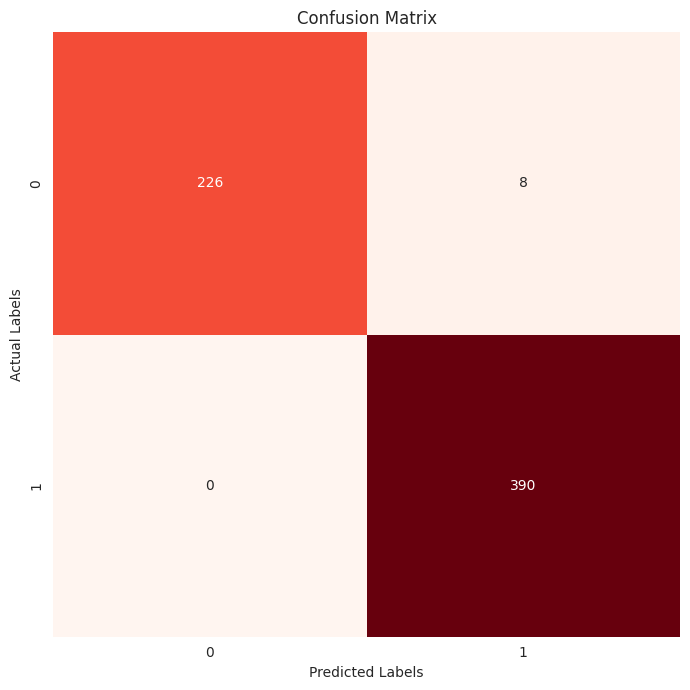

In [31]:
conf_matrix = confusion_matrix(y_true= test_set.classes, y_pred= predicted_classes)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap='Reds');
plt.title('Confusion Matrix');
plt.xlabel('Predicted Labels');
plt.ylabel('Actual Labels');
plt.tight_layout();

In [32]:
print(classification_report(test_set.classes, predicted_classes))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       234
           1       0.98      1.00      0.99       390

    accuracy                           0.99       624
   macro avg       0.99      0.98      0.99       624
weighted avg       0.99      0.99      0.99       624



<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">

Now it's time to change the Accelerator status from GPU P100 to None in order to save the remaining running time out of 30 hours in a week.
</div>

<div style="color:white;
            display:fill;
            border-radius:5px;
            background-color:#44479b;
            font-size:110%;
            font-family:Verdana;
            letter-spacing:0.5px;
            text-align:center">
  <h1 id="Conclusion" style="padding: 10px; color:white; text-align:center;">
   5. Conclusion
    <a class="anchor-link" href="https://www.kaggle.com/code/amirhoseinsedaghati/lung-cancer-detection-using-cnn-0-98-f1-acc#Conclusion"">¶</a>
  </h1>
</div>


<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">

As you can see, we have achieved a reliable and accurate model. In crucial tasks such as illness detection and fraud detection, where we deal with human health and assets, we prioritize a high recall metric over precision. As you can see, this objective has also been fulfilled.<br />
    
<br />If you like it, Please support me by giving me an upvote, THANK YOU :)
</div>

In [41]:
!pip freeze > /content/requirements.txt
